## Final Project: ML for Cloud and Cognitive Services

In this project, we use PySpark and SparkML to analyze Titanic data and build classification model to predict whether passenger will survive based on their travel information and bio.

Group:

* Abla El Moussouli
* Thomas Colangelo
* Yohanes Nuwara

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e9278766db4b307b2e96b0b1506dac17c00ed667a0a8439dbce64a62add1154f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql.functions import col, sum as pyspark_sum
from pyspark.sql import SparkSession
from pyspark.sql.functions import round
from pyspark.sql.functions import regexp_extract
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("example") \
    .getOrCreate()

# Verify SparkSession
print(spark)

In [ ]:
df = spark.read \
    .format("csv") \
    .option("inferSchema", True) \
    .option("header", "true") \
    .option("sep", ",") \
    .load("train.csv")

In [ ]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



## Data preprocessing

In [ ]:
# droping cabin and passenger name
df1 = df.drop("cabin","name")

In [ ]:
# Count the number of nulls in each column
null_counts = df1.select([pyspark_sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns])

num_rows = df1.count()

# Print the number of rows
print("Number of rows before null removal:", num_rows)

# Print out the number of nulls in each column
print("Number of nulls in each column before removal:")
null_counts.show()

# Remove rows containing null values
df_cleaned = df1.na.drop()

print()

num_rows2 = df_cleaned.count()

# Print the number of rows
print("Number of rows after null removal:", num_rows2)

# Count the number of nulls in each column
null_counts2 = df_cleaned.select([pyspark_sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns])

# Print out the number of nulls in each column
print("Number of nulls in each column after removal:")
null_counts2.show()

Number of rows before null removal: 891
Number of nulls in each column before removal:
+-----------+--------+------+---+---+-----+-----+------+----+--------+
|PassengerId|Survived|Pclass|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|
+-----------+--------+------+---+---+-----+-----+------+----+--------+
|          0|       0|     0|  0|177|    0|    0|     0|   0|       2|
+-----------+--------+------+---+---+-----+-----+------+----+--------+


Number of rows after null removal: 712
Number of nulls in each column after removal:
+-----------+--------+------+---+---+-----+-----+------+----+--------+
|PassengerId|Survived|Pclass|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|
+-----------+--------+------+---+---+-----+-----+------+----+--------+
|          0|       0|     0|  0|  0|    0|    0|     0|   0|       0|
+-----------+--------+------+---+---+-----+-----+------+----+--------+



In [ ]:
# Round decimal values to nearest integer in the 'Age' column
df_cleaned = df_cleaned.withColumn("Age", round("Age").cast("int"))
#df_cleaned = df_cleaned.withColumn("Fare", round("Fare").cast("int"))

# Show the DataFrame after rounding the 'Age' column
df_cleaned.show()

+-----------+--------+------+------+---+-----+-----+----------------+-------+--------+
|PassengerId|Survived|Pclass|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Embarked|
+-----------+--------+------+------+---+-----+-----+----------------+-------+--------+
|          1|       0|     3|  male| 22|    1|    0|       A/5 21171|   7.25|       S|
|          2|       1|     1|female| 38|    1|    0|        PC 17599|71.2833|       C|
|          3|       1|     3|female| 26|    0|    0|STON/O2. 3101282|  7.925|       S|
|          4|       1|     1|female| 35|    1|    0|          113803|   53.1|       S|
|          5|       0|     3|  male| 35|    0|    0|          373450|   8.05|       S|
|          7|       0|     1|  male| 54|    0|    0|           17463|51.8625|       S|
|          8|       0|     3|  male|  2|    3|    1|          349909| 21.075|       S|
|          9|       1|     3|female| 27|    0|    2|          347742|11.1333|       S|
|         10|       1|     2|female| 14|   

In [ ]:
# Define a regex to extract the consecutive numeric part from the end of the Ticket value
pattern = r'(\d+)$'

# Apply the regular expression pattern to the Ticket column
df_cleaned2 = df_cleaned.withColumn("Ticket", regexp_extract("Ticket", pattern, 1))

# Show the DataFrame after the transformation
df_cleaned2.show(truncate=False)

+-----------+--------+------+------+---+-----+-----+-------+-------+--------+
|PassengerId|Survived|Pclass|Sex   |Age|SibSp|Parch|Ticket |Fare   |Embarked|
+-----------+--------+------+------+---+-----+-----+-------+-------+--------+
|1          |0       |3     |male  |22 |1    |0    |21171  |7.25   |S       |
|2          |1       |1     |female|38 |1    |0    |17599  |71.2833|C       |
|3          |1       |3     |female|26 |0    |0    |3101282|7.925  |S       |
|4          |1       |1     |female|35 |1    |0    |113803 |53.1   |S       |
|5          |0       |3     |male  |35 |0    |0    |373450 |8.05   |S       |
|7          |0       |1     |male  |54 |0    |0    |17463  |51.8625|S       |
|8          |0       |3     |male  |2  |3    |1    |349909 |21.075 |S       |
|9          |1       |3     |female|27 |0    |2    |347742 |11.1333|S       |
|10         |1       |2     |female|14 |1    |0    |237736 |30.0708|C       |
|11         |1       |3     |female|4  |1    |1    |9549   |16.7

In [ ]:
# StringIndexer to convert 'Embarked' column into indices
indexer = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndexed")

# Fit the StringIndexer to the DataFrame
indexer_model = indexer.fit(df_cleaned2)

# Transform the DataFrame
df_indexed = indexer_model.transform(df_cleaned2)

df_indexed = df_indexed.withColumn("Embarked", col("EmbarkedIndexed").cast("int"))
df_indexed = df_indexed.drop("EmbarkedIndexed")
# Show the DataFrame with the indexed 'Embarked' column
df_indexed.show()

+-----------+--------+------+------+---+-----+-----+-------+-------+--------+
|PassengerId|Survived|Pclass|   Sex|Age|SibSp|Parch| Ticket|   Fare|Embarked|
+-----------+--------+------+------+---+-----+-----+-------+-------+--------+
|          1|       0|     3|  male| 22|    1|    0|  21171|   7.25|       0|
|          2|       1|     1|female| 38|    1|    0|  17599|71.2833|       1|
|          3|       1|     3|female| 26|    0|    0|3101282|  7.925|       0|
|          4|       1|     1|female| 35|    1|    0| 113803|   53.1|       0|
|          5|       0|     3|  male| 35|    0|    0| 373450|   8.05|       0|
|          7|       0|     1|  male| 54|    0|    0|  17463|51.8625|       0|
|          8|       0|     3|  male|  2|    3|    1| 349909| 21.075|       0|
|          9|       1|     3|female| 27|    0|    2| 347742|11.1333|       0|
|         10|       1|     2|female| 14|    1|    0| 237736|30.0708|       1|
|         11|       1|     3|female|  4|    1|    1|   9549|   1

In [ ]:
# StringIndexer to convert 'Embarked' column into indices
indexer = StringIndexer(inputCol="Sex", outputCol="SexIndexed")

# Fit the StringIndexer to the DataFrame
indexer_model = indexer.fit(df_indexed)

# Transform the DataFrame
df_indexed2 = indexer_model.transform(df_indexed)

df_indexed2 = df_indexed2.withColumn("Sex", col("SexIndexed").cast("int"))
df_indexed2 = df_indexed2.drop("SexIndexed")
# Show the DataFrame with the indexed 'Embarked' column
df_indexed2.show()

+-----------+--------+------+---+---+-----+-----+-------+-------+--------+
|PassengerId|Survived|Pclass|Sex|Age|SibSp|Parch| Ticket|   Fare|Embarked|
+-----------+--------+------+---+---+-----+-----+-------+-------+--------+
|          1|       0|     3|  0| 22|    1|    0|  21171|   7.25|       0|
|          2|       1|     1|  1| 38|    1|    0|  17599|71.2833|       1|
|          3|       1|     3|  1| 26|    0|    0|3101282|  7.925|       0|
|          4|       1|     1|  1| 35|    1|    0| 113803|   53.1|       0|
|          5|       0|     3|  0| 35|    0|    0| 373450|   8.05|       0|
|          7|       0|     1|  0| 54|    0|    0|  17463|51.8625|       0|
|          8|       0|     3|  0|  2|    3|    1| 349909| 21.075|       0|
|          9|       1|     3|  1| 27|    0|    2| 347742|11.1333|       0|
|         10|       1|     2|  1| 14|    1|    0| 237736|30.0708|       1|
|         11|       1|     3|  1|  4|    1|    1|   9549|   16.7|       0|
|         12|       1|   

In [ ]:
# StringIndexer to convert 'Embarked' column into indices
indexer = StringIndexer(inputCol="Ticket", outputCol="TicketIndexed")

# Fit the StringIndexer to the DataFrame
indexer_model = indexer.fit(df_indexed2)

# Transform the DataFrame
df_indexed3 = indexer_model.transform(df_indexed2)

df_indexed3 = df_indexed3.withColumn("Ticket", col("TicketIndexed").cast("int"))
df_indexed3 = df_indexed3.drop("TicketIndexed")
# Show the DataFrame with the indexed 'Embarked' column
df_indexed3.show()

+-----------+--------+------+---+---+-----+-----+------+-------+--------+
|PassengerId|Survived|Pclass|Sex|Age|SibSp|Parch|Ticket|   Fare|Embarked|
+-----------+--------+------+---+---+-----+-----+------+-------+--------+
|          1|       0|     3|  0| 22|    1|    0|   207|   7.25|       0|
|          2|       1|     1|  1| 38|    1|    0|   188|71.2833|       1|
|          3|       1|     3|  1| 26|    0|    0|   327|  7.925|       0|
|          4|       1|     1|  1| 35|    1|    0|    39|   53.1|       0|
|          5|       0|     3|  0| 35|    0|    0|   498|   8.05|       0|
|          7|       0|     1|  0| 54|    0|    0|   174|51.8625|       0|
|          8|       0|     3|  0|  2|    3|    1|    13| 21.075|       0|
|          9|       1|     3|  1| 27|    0|    2|    33|11.1333|       0|
|         10|       1|     2|  1| 14|    1|    0|    64|30.0708|       1|
|         11|       1|     3|  1|  4|    1|    1|   109|   16.7|       0|
|         12|       1|     1|  1| 58| 

In [ ]:
df_indexed3.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: integer (nullable = true)



In [ ]:
# Print the number of rows in the dataset
print("Number of rows in the dataset:", df_indexed3.count())

Number of rows in the dataset: 712


## Exploratory data analysis

In [ ]:
# Show summary statistics for the dataset
df_indexed3.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|summary|       PassengerId|          Survived|            Pclass|               Sex|               Age|             SibSp|              Parch|            Ticket|              Fare|          Embarked|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|  count|               712|               712|               712|               712|               712|               712|                712|               712|               712|               712|
|   mean|448.58988764044943|0.4044943820224719| 2.240168539325843|0.3637640449438202|29.655898876404493|0.5140449438202247|0.43258426966292135|213.87780898876406| 34.56725140449432|0.2612359550561

1. 60% died

2. Balanced social class but slightly skewed towards more wealthy

3. Mostly men

4. Average age 30 years old

5. Average of 0.5 siblings/spouses on board

6. Average of 0.4 parents/children on board

7. Points 5 and 6 indicate a balanced crowd, skewed towards couples and siblings instead of parents with children

8. Average low fair, with many outliers, probably luxury tickets were sold

9. Most people embarked at the first port

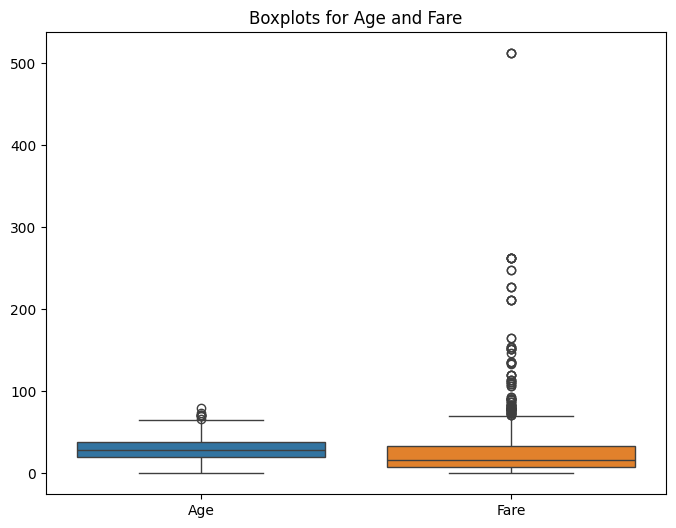

In [ ]:
# Select 'Age' and 'Fare' columns
df_selected = df_indexed3.select("Age", "Fare")

# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df_selected.toPandas()

# Plot boxplots for 'Age' and 'Fare' columns
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pd)
plt.title("Boxplots for Age and Fare")
plt.show()

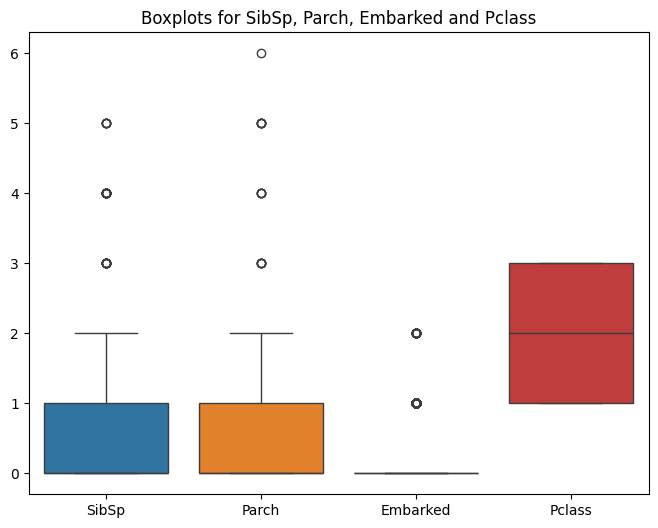

In [ ]:
# Select 'Age' and 'Fare' columns
df_selected1 = df_indexed3.select("SibSp", "Parch", "Embarked","Pclass")

# Convert PySpark DataFrame to Pandas DataFrame
df_pd1 = df_selected1.toPandas()

# Plot boxplots for 'Age' and 'Fare' columns
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pd1)
plt.title("Boxplots for SibSp, Parch, Embarked and Pclass")
plt.show()


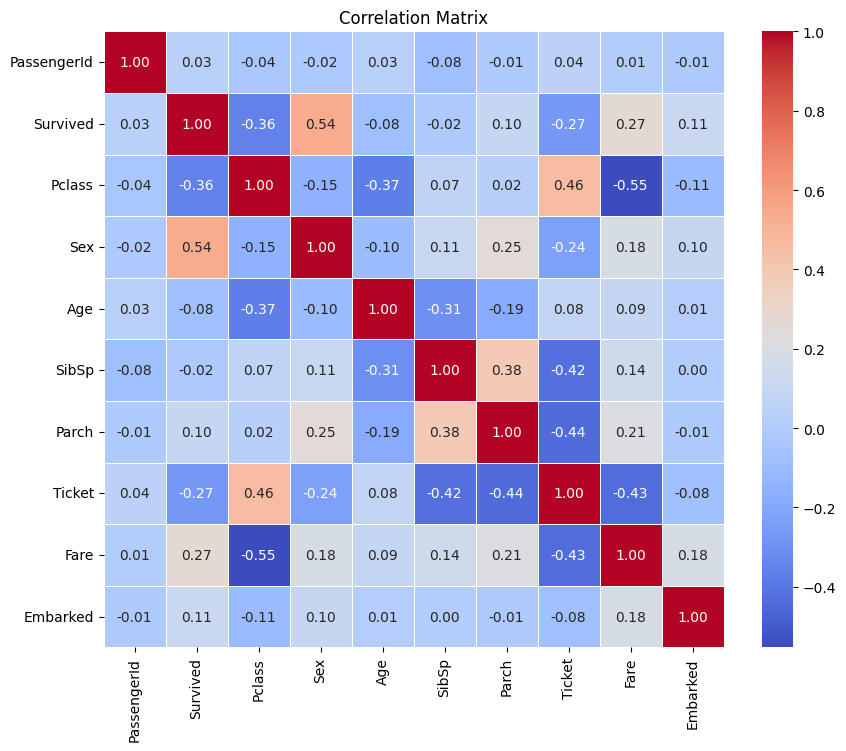

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
df_pd2 = df_indexed3.toPandas()

# Calculate correlation matrix
correlation_matrix = df_pd2.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Classification modeling

Split 60% training 40% test data

In [ ]:
feature = VectorAssembler(inputCols=df_indexed3.columns[2:],outputCol="features")

feature = VectorAssembler(inputCols=["Age","Pclass","Sex","SibSp","Parch","Fare","Embarked"],
                          outputCol="features")

feature_vector= feature.transform(df_indexed3)

feature_vector.show()

+-----------+--------+------+---+---+-----+-----+------+-------+--------+--------------------+
|PassengerId|Survived|Pclass|Sex|Age|SibSp|Parch|Ticket|   Fare|Embarked|            features|
+-----------+--------+------+---+---+-----+-----+------+-------+--------+--------------------+
|          1|       0|     3|  0| 22|    1|    0|   207|   7.25|       0|[22.0,3.0,0.0,1.0...|
|          2|       1|     1|  1| 38|    1|    0|   188|71.2833|       1|[38.0,1.0,1.0,1.0...|
|          3|       1|     3|  1| 26|    0|    0|   327|  7.925|       0|[26.0,3.0,1.0,0.0...|
|          4|       1|     1|  1| 35|    1|    0|    39|   53.1|       0|[35.0,1.0,1.0,1.0...|
|          5|       0|     3|  0| 35|    0|    0|   498|   8.05|       0|(7,[0,1,5],[35.0,...|
|          7|       0|     1|  0| 54|    0|    0|   174|51.8625|       0|(7,[0,1,5],[54.0,...|
|          8|       0|     3|  0|  2|    3|    1|    13| 21.075|       0|[2.0,3.0,0.0,3.0,...|
|          9|       1|     3|  1| 27|    0|    2| 

In [ ]:
(training_data, test_data) = feature_vector.randomSplit([0.6, 0.4],seed = 3)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

### Random Forest

F1-score test: 0.784

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="Survived", featuresCol="features")
rf_model = rf.fit(training_data)
rf_prediction = rf_model.transform(test_data)
rf_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       1|[38.0,1.0,1.0,1.0...|
|       0.0|       1|[26.0,3.0,1.0,0.0...|
|       1.0|       1|[35.0,1.0,1.0,1.0...|
|       0.0|       0|[2.0,3.0,0.0,3.0,...|
|       0.0|       1|[27.0,3.0,1.0,0.0...|
|       1.0|       1|[4.0,3.0,1.0,1.0,...|
|       0.0|       0|(7,[0,1,5],[20.0,...|
|       0.0|       0|[39.0,3.0,0.0,1.0...|
|       1.0|       0|[14.0,3.0,1.0,0.0...|
|       1.0|       1|[55.0,2.0,1.0,0.0...|
|       0.0|       1|(7,[0,1,5],[34.0,...|
|       1.0|       1|[15.0,3.0,1.0,0.0...|
|       0.0|       0|[8.0,3.0,1.0,3.0,...|
|       0.0|       1|[38.0,3.0,1.0,1.0...|
|       0.0|       0|[40.0,1.0,0.0,0.0...|
|       0.0|       0|[28.0,1.0,0.0,1.0...|
|       1.0|       1|[14.0,3.0,1.0,1.0...|
|       1.0|       0|[27.0,2.0,1.0,1.0...|
|       1.0|       0|[18.0,3.0,1.0,1.0...|
|       0.0|       0|[7.0,3.0,0.0,4.0,...|
+----------

In [ ]:
rf_accuracy = evaluator.evaluate(rf_prediction)
print("Accuracy of RandomForestClassifier is = %g"% (rf_accuracy))
print("Test Error of RandomForestClassifier  = %g " % (1.0 - rf_accuracy))

# Calculate additional metrics
precision = evaluator.evaluate(rf_prediction, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(rf_prediction, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(rf_prediction, {evaluator.metricName: "f1"})

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy of RandomForestClassifier is = 0.791411
Test Error of RandomForestClassifier  = 0.208589 
Precision: 0.7957738741723244
Recall: 0.7914110429447854
F1 Score: 0.7838657064224692


### Support Vector Classifier

F1-score test: 0.768

In [ ]:
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(labelCol="Survived", featuresCol="features")
svm_model = svm.fit(training_data)
svm_prediction = svm_model.transform(test_data)
svm_prediction.select("prediction", "Survived", "features").show()


+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       1|[38.0,1.0,1.0,1.0...|
|       1.0|       1|[26.0,3.0,1.0,0.0...|
|       1.0|       1|[35.0,1.0,1.0,1.0...|
|       0.0|       0|[2.0,3.0,0.0,3.0,...|
|       1.0|       1|[27.0,3.0,1.0,0.0...|
|       1.0|       1|[4.0,3.0,1.0,1.0,...|
|       0.0|       0|(7,[0,1,5],[20.0,...|
|       0.0|       0|[39.0,3.0,0.0,1.0...|
|       1.0|       0|[14.0,3.0,1.0,0.0...|
|       1.0|       1|[55.0,2.0,1.0,0.0...|
|       0.0|       1|(7,[0,1,5],[34.0,...|
|       1.0|       1|[15.0,3.0,1.0,0.0...|
|       1.0|       0|[8.0,3.0,1.0,3.0,...|
|       0.0|       1|[38.0,3.0,1.0,1.0...|
|       0.0|       0|[40.0,1.0,0.0,0.0...|
|       0.0|       0|[28.0,1.0,0.0,1.0...|
|       1.0|       1|[14.0,3.0,1.0,1.0...|
|       1.0|       0|[27.0,2.0,1.0,1.0...|
|       1.0|       0|[18.0,3.0,1.0,1.0...|
|       0.0|       0|[7.0,3.0,0.0,4.0,...|
+----------

In [ ]:
rf_accuracy = evaluator.evaluate(svm_prediction)
print("Accuracy of RandomForestClassifier is = %g"% (rf_accuracy))
print("Test Error of RandomForestClassifier  = %g " % (1.0 - rf_accuracy))

# Calculate additional metrics
precision = evaluator.evaluate(svm_prediction, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(svm_prediction, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(svm_prediction, {evaluator.metricName: "f1"})

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy of RandomForestClassifier is = 0.773006
Test Error of RandomForestClassifier  = 0.226994 
Precision: 0.771800555993988
Recall: 0.7730061349693251
F1 Score: 0.767881994230073


### Multi Layer Perceptron

F1-score test data: 0.801

Split 60% of training data has the best F1-score using (2,16,4,2) neuron (2 hidden layers)

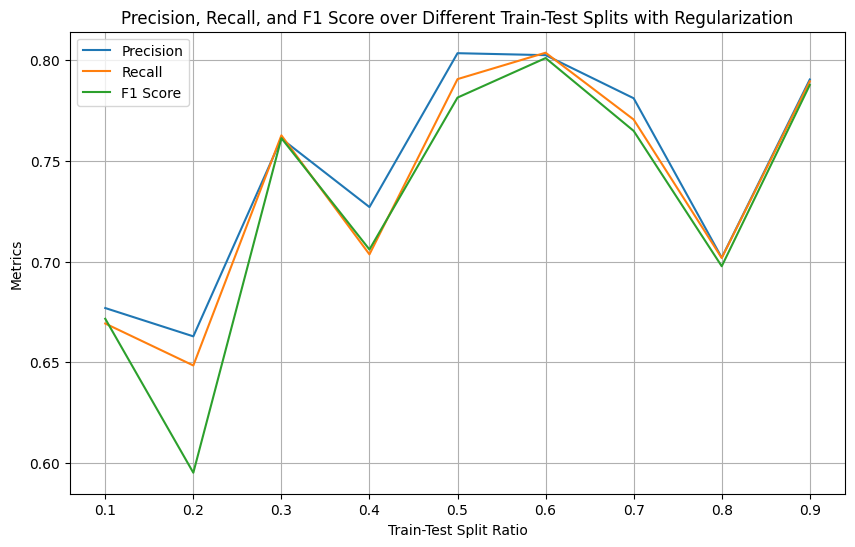

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize lists to store metrics
precisions = []
recalls = []
f1_scores = []
split_ratios = []

# Define a range of split ratios
split_range = np.linspace(0.1, 0.9, 9)

# Regularization parameter
reg_param = 0.1

# Loop through different train-test split ratios
for split_ratio in split_range:
    # Split the data
    (training_data, test_data) = feature_vector.randomSplit([split_ratio, 1 - split_ratio], seed=3)

    # Define the layers for the Multilayer Perceptron Classifier
    input_size = len(training_data.select("features").first()[0])
    output_size = 2  # Assuming binary classification
    layers = [input_size, 16, 4, output_size]

    # Initialize the Multilayer Perceptron Classifier with L2 regularization
    mlp_classifier = MultilayerPerceptronClassifier(
        layers=layers,
        labelCol="Survived",
        featuresCol="features",
        stepSize=0.01,
        maxIter=1000,
        blockSize=128,
        seed=123,
        solver="l-bfgs",
        tol=1e-6
    )

    # Fit the classifier to the training data
    model = mlp_classifier.fit(training_data)

    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction")

    # Calculate metrics
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    # Store metrics and split ratio
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    split_ratios.append(split_ratio)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(split_ratios, precisions, label='Precision')
plt.plot(split_ratios, recalls, label='Recall')
plt.plot(split_ratios, f1_scores, label='F1 Score')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('Metrics')
plt.title('Precision, Recall, and F1 Score over Different Train-Test Splits with Regularization')
plt.legend()
plt.grid(True)
plt.show()


choosing 0.6

In [ ]:
(training_data, test_data) = feature_vector.randomSplit([0.6, 0.4], seed=3)


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the layers for the Multilayer Perceptron Classifier
input_size = len(training_data.select("features").first()[0])
output_size = 2  # Assuming binary classification
layers = [input_size, 16,4, output_size]

# Initialize the Multilayer Perceptron Classifier with L2 regularization
mlp_classifier = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Survived",
    featuresCol="features",
    stepSize=0.01,
    maxIter=1000,
    blockSize=128,
    seed=123,
    solver="l-bfgs",
    tol=1e-6
)

# Fit the classifier to the training data
model_final = mlp_classifier.fit(training_data)

# Make predictions on the test data
predictions_final = model_final.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_final)
print("Accuracy of MultilayerPerceptronClassifier:", accuracy)

# Calculate additional metrics
precision = evaluator.evaluate(predictions_final, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_final, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions_final, {evaluator.metricName: "f1"})

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy of MultilayerPerceptronClassifier: 0.803680981595092
Precision: 0.8024738182428992
Recall: 0.803680981595092
F1 Score: 0.8010217116824112


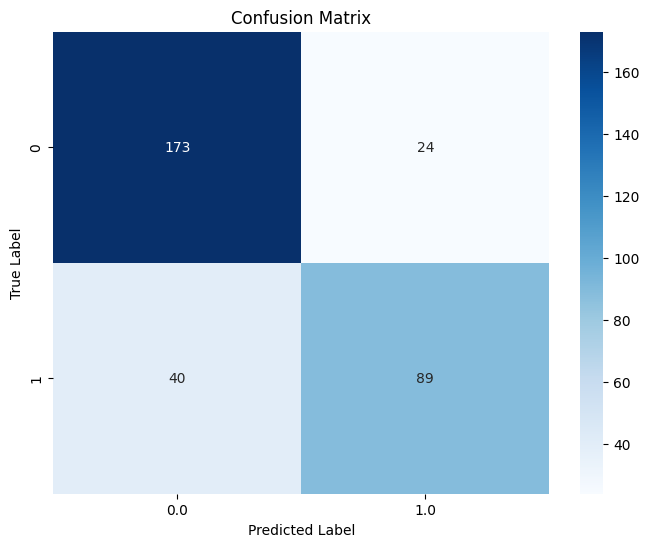

In [ ]:
# Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
confusion_matrix = predictions_final.groupBy("Survived", "prediction").count().orderBy("Survived", "prediction")

# Convert the confusion matrix to a Pandas DataFrame for easier visualization
confusion_matrix_pd = confusion_matrix.toPandas()

# Create a pivot table for visualization
confusion_matrix_pivot = confusion_matrix_pd.pivot(index="Survived", columns="prediction", values="count")

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Hyperparameter grid search of MLP

F1-score test data improved to 0.804

Parameter: MaxIter and NumSteps

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define the layers for the Multilayer Perceptron Classifier
input_size = len(training_data.select("features").first()[0])
output_size = 2  # Assuming binary classification
layers = [input_size, 16,4, output_size]

clf = MultilayerPerceptronClassifier(labelCol='Survived',featuresCol='features',layers=layers,
                                    seed=123,solver="l-bfgs",tol=1e-6)

pipeline = Pipeline(stages=[clf])
x1 = 'stepSize'
x2 = 'maxIter'
paramGrid = ParamGridBuilder() \
    .addGrid(getattr(clf,x1), [0.005, 0.01, 0.05]) \
    .addGrid(getattr(clf,x2),[300,500,1000])\
    .build()
evaluator = MulticlassClassificationEvaluator(labelCol='Survived', predictionCol='prediction', metricName='accuracy')

crossval = CrossValidator(estimator=pipeline,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=evaluator,
                                      numFolds=2)

cvModel = crossval.fit(training_data)

In [ ]:
print("Best step size: ", cvModel.bestModel.stages[-1]._java_obj.getStepSize())
print("Best max iter: ", cvModel.bestModel.stages[-1]._java_obj.getMaxIter())


Best step size:  0.005
Best max iter:  300


In [ ]:
# Make predictions on the test data
predictions_final = cvModel.bestModel.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_final)
print("Accuracy of MultilayerPerceptronClassifier:", accuracy)

# Calculate additional metrics
precision = evaluator.evaluate(predictions_final, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_final, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions_final, {evaluator.metricName: "f1"})

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy of MultilayerPerceptronClassifier: 0.8067484662576687
Precision: 0.8066335528414101
Recall: 0.8067484662576687
F1 Score: 0.8030761860831538


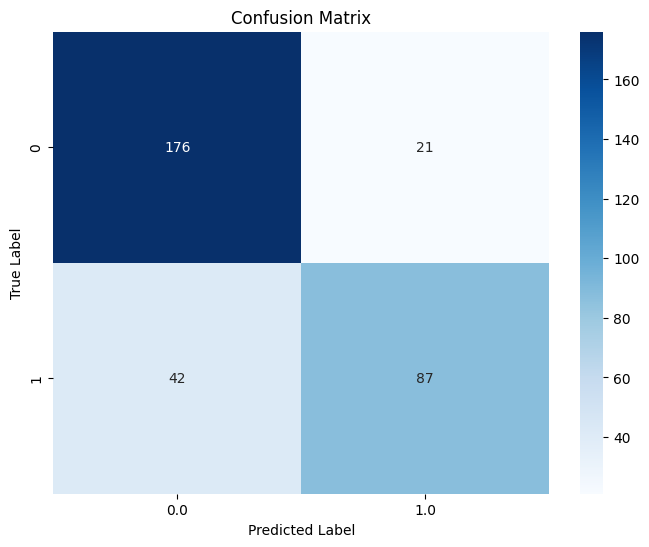

In [ ]:
# Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
confusion_matrix = predictions_final.groupBy("Survived", "prediction").count().orderBy("Survived", "prediction")

# Convert the confusion matrix to a Pandas DataFrame for easier visualization
confusion_matrix_pd = confusion_matrix.toPandas()

# Create a pivot table for visualization
confusion_matrix_pivot = confusion_matrix_pd.pivot(index="Survived", columns="prediction", values="count")

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
